In [70]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-08-02 07:06:29,509: Credentials are already in use. The existing account in the session will be replaced.


In [71]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

In [72]:
cir = QuantumCircuit(2,2)

In [73]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

ibmqfactory.load_account:WARNING:2022-08-02 07:06:34,623: Credentials are already in use. The existing account in the session will be replaced.


In [74]:
backend_config = backend.configuration()

In [75]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")    # The configuration returns dt in seconds, so multiply by
                                        # 1e9 to get nanoseconds

Sampling time: 0.2222222222222222 ns


In [76]:
backend.configuration().timing_constraints

{'acquire_alignment': 16,
 'granularity': 16,
 'min_length': 64,
 'pulse_alignment': 1}

In [77]:
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']

In [78]:
import numpy as np

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")

Least common multiple of acquire_alignment and pulse_alignment: 16


In [79]:
backend_defaults = backend.defaults()

In [80]:
#Finding the qubit Frequency using a Frequency Sweep

In [81]:
# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-7

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz

# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange(frequency_min / GHz, 
                            frequency_max / GHz, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")

Qubit 0 has an estimated frequency of 4.962285987813341 GHz.
The sweep will go from 4.942285987813341 GHz to 4.982285987813341 GHz in steps of 1.0 MHz.


In [82]:
def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

In [83]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

In [84]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [85]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                           # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.05

# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)

In [86]:
sweep_gate = Gate("sweep", 1, [freq])

qc_sweep = QuantumCircuit(1, 1)

qc_sweep.append(sweep_gate, [0])
qc_sweep.measure(0, 0)
qc_sweep.add_calibration(sweep_gate, (0,), sweep_sched, [freq])

# Create the frequency settings for the sweep (MUST BE IN HZ)
frequencies_Hz = frequencies_GHz*GHz
exp_sweep_circs = [qc_sweep.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

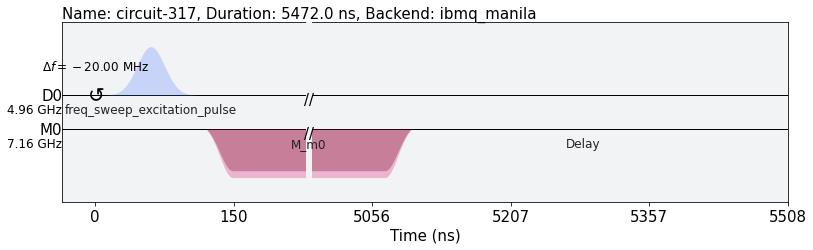

In [87]:
from qiskit import schedule

sweep_schedule = schedule(exp_sweep_circs[0], backend)
sweep_schedule.draw(backend=backend)

In [88]:
num_shots_per_frequency = 1024

job = backend.run(exp_sweep_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [89]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


In [90]:
frequency_sweep_results = job.result(timeout=120) # timeout parameter set to 120 seconds

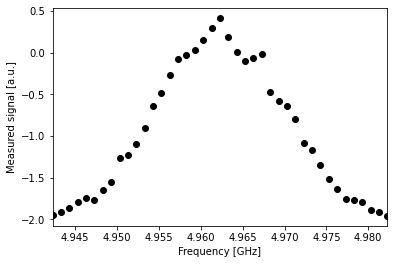

In [91]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [92]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

In [93]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C,
                                 [1, 4.975, 1, -2] # initial parameters for curve_fit
                                )

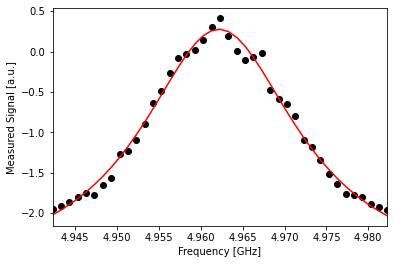

In [94]:
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [95]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")

We've updated our qubit frequency estimate from 4.96229 GHz to 4.96218 GHz.


In [96]:
#Calibrating and using a Pi Pulse

In [97]:
#Calibrating  Pulses using a Rabi Experiment

In [98]:
# This experiment uses these values from the previous experiment:
# `qubit`,and
# `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0
drive_amp_max = 0.75
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [99]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)

In [100]:
rabi_gate = Gate("rabi", 1, [drive_amp])

qc_rabi = QuantumCircuit(1, 1)

qc_rabi.append(rabi_gate, [0])
qc_rabi.measure(0, 0)
qc_rabi.add_calibration(rabi_gate, (0,), rabi_sched, [drive_amp])

exp_rabi_circs = [qc_rabi.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

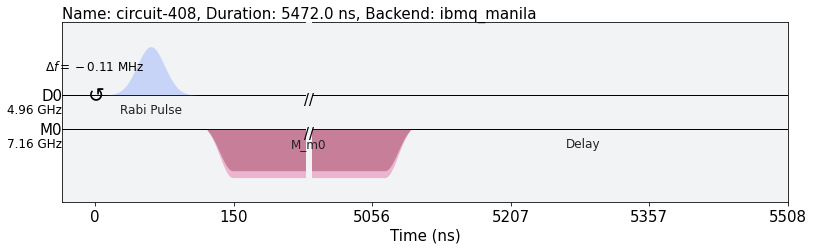

In [101]:
rabi_schedule = schedule(exp_rabi_circs[-1], backend)
rabi_schedule.draw(backend=backend)

In [102]:
num_shots_per_point = 1024

job = backend.run(exp_rabi_circs, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [103]:
rabi_results = job.result(timeout=120)

In [104]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

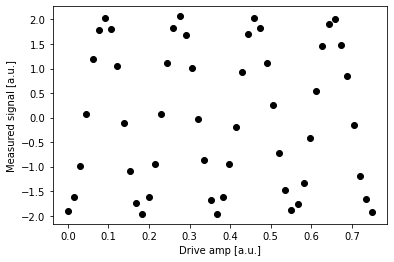

In [105]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

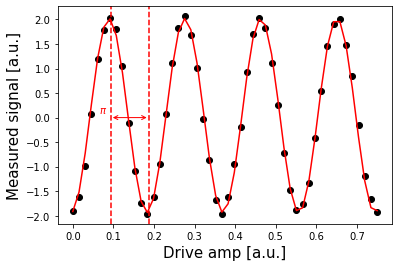

In [106]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [2, 0, 0.2, 0])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')

drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period/2, color='red', linestyle='--')
plt.axvline(drive_period, color='red', linestyle='--')
plt.annotate("", xy=(drive_period, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [107]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.09356038985538272


In [108]:
#Our Pi pulse!

In [109]:
with pulse.build(backend) as pi_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)

In [110]:
#Determining 0 vs 1

In [111]:
# Ground state 
qc_gnd = QuantumCircuit(1, 1)
qc_gnd.measure(0, 0)

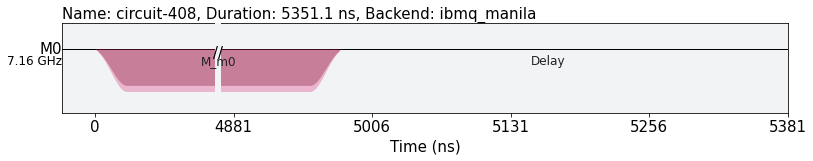

In [112]:
gnd_schedule = schedule(qc_gnd, backend)
gnd_schedule.draw(backend=backend)

In [113]:
# Excited state
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse)

In [114]:
qc_exc = QuantumCircuit(1, 1)
qc_exc.x(0)
qc_exc.measure(0, 0)

qc_exc.add_calibration("x", (0,), exc_schedule, [])

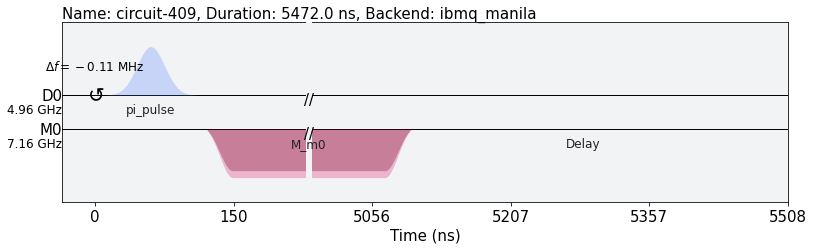

In [115]:
exec_schedule = schedule(qc_exc, backend)
exec_schedule.draw(backend=backend)

In [116]:
# Execution settings
num_shots = 1024

job = backend.run([qc_gnd, qc_exc], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [117]:
gnd_exc_results = job.result(timeout=120)

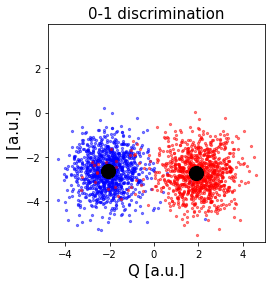

In [118]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor

plt.figure()

# Plot all the results
# All results from the ground state are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the excited state are plotted in red
plt.scatter(np.real(exc_results), np.imag(exc_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_exc = np.mean(exc_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_exc), np.imag(mean_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

In [119]:
import math

def classify(point: complex):
    """Classify the given state as |0> or |1>."""
    def distance(a, b):
        return math.sqrt((np.real(a) - np.real(b))**2 + (np.imag(a) - np.imag(b))**2)
    return int(distance(point, mean_exc) < distance(point, mean_gnd))

In [51]:
# Measuring T1 using Inversion Recovery

In [52]:
# T1 experiment parameters
time_max_sec = 450 * us
time_step_sec = 6.5 * us
delay_times_sec = np.arange(1 * us, time_max_sec, time_step_sec)

# We will use the same `pi_pulse` and qubit frequency that we calibrated and used before

In [53]:
delay = Parameter('delay')
qc_t1 = QuantumCircuit(1, 1)

qc_t1.x(0)
qc_t1.delay(delay, 0)
qc_t1.measure(0, 0)
qc_t1.add_calibration("x", (0,), pi_pulse)

exp_t1_circs = [qc_t1.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

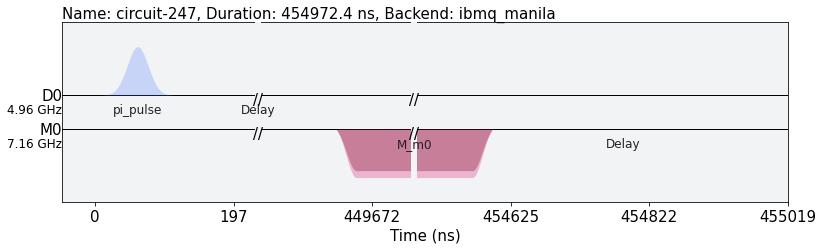

In [54]:
sched_idx = -1
t1_schedule = schedule(exp_t1_circs[sched_idx], backend)
t1_schedule.draw(backend=backend)

In [55]:
# Execution settings
num_shots = 256

job = backend.run(exp_t1_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [56]:
t1_results = job.result(timeout=120)

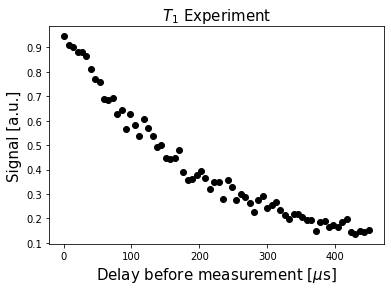

In [57]:
t1_values = []

for i in range(len(delay_times_sec)):
    iq_data = t1_results.get_memory(i)[:,qubit] * scale_factor
    t1_values.append(sum(map(classify, iq_data)) / num_shots)

plt.scatter(delay_times_sec/us, t1_values, color='black') 
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.show()

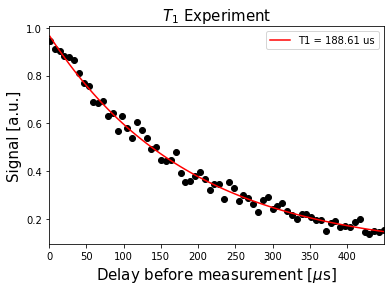

In [58]:
# Fit the data
fit_params, y_fit = fit_function(delay_times_sec/us, t1_values, 
            lambda x, A, C, T1: (A * np.exp(-x / T1) + C),
            [-3, 3, 100]
            )

_, _, T1 = fit_params

plt.scatter(delay_times_sec/us, t1_values, color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"T1 = {T1:.2f} us")
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("$T_1$ Experiment", fontsize=15)
plt.xlabel('Delay before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Signal [a.u.]', fontsize=15)
plt.legend()
plt.show()

In [120]:
#Determining qubit Coherence

In [121]:
#Measuring the qubit Frequency Precisely using a Ramsey Experiment

In [122]:
# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [123]:
detuning_MHz = 2 
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [124]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [125]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

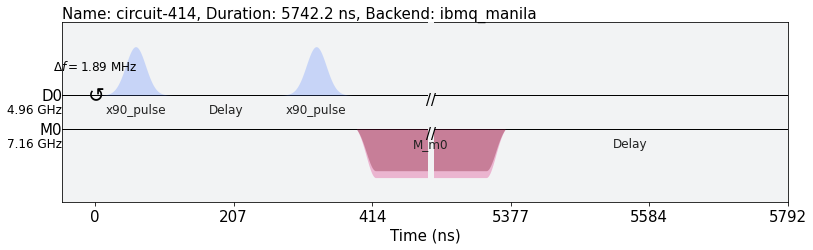

In [126]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [127]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [128]:
ramsey_results = job.result(timeout=120)

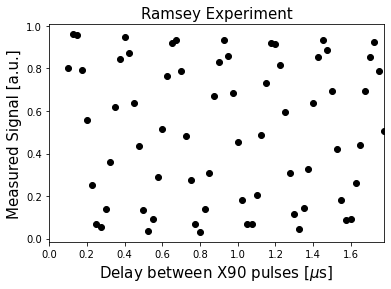

In [129]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

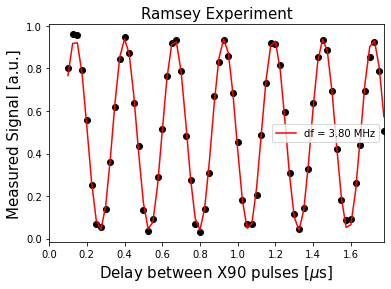

In [130]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [1, 4, 0, 0.3]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [139]:
precise_qubit_freq = rough_qubit_frequency + (detuning_MHz - del_f_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 4.96037 GHz. It used to be 4.962176 GHz


In [140]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [141]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

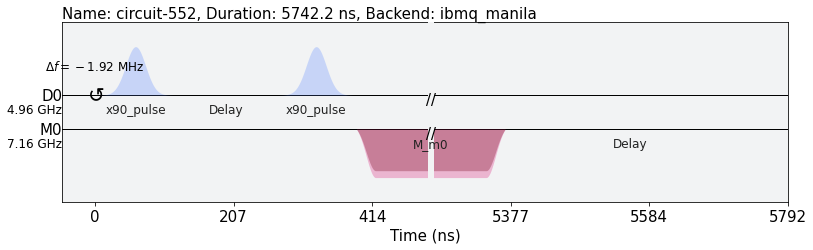

In [142]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [143]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [144]:
ramsey_results = job.result(timeout=120)

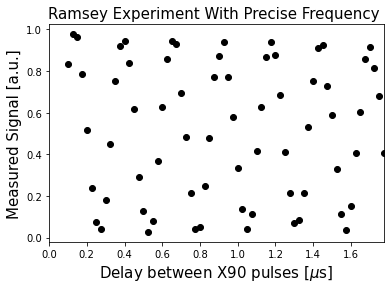

In [145]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment With Precise Frequency ", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

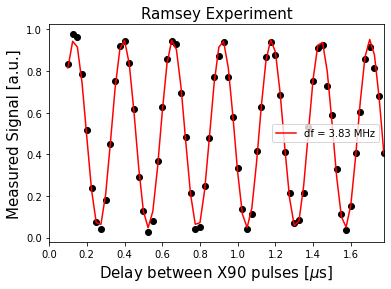

In [146]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [1, 4, 0, 0.3]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [147]:
detuning_MHz = 2 
ramsey_frequency = round(precise_qubit_freq + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [148]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [149]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

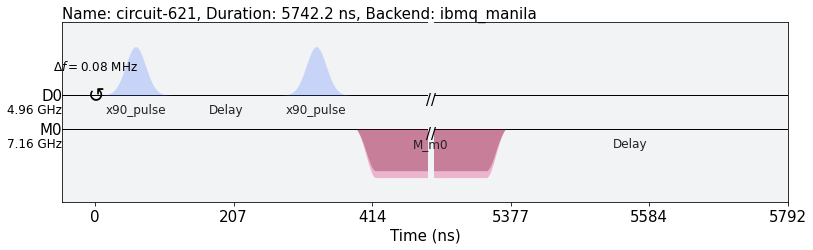

In [150]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [151]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


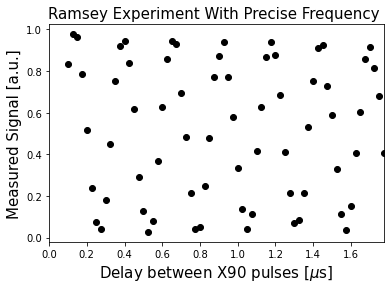

In [152]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment With Precise Frequency ", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

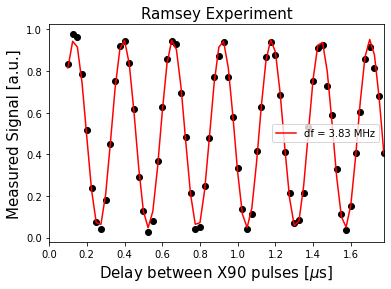

In [153]:
fit_params, y_fit = fit_function(delay_times_sec/us, np.real(ramsey_values),
                                 lambda x, A, del_f_MHz, C, B: (
                                          A * np.cos(2*np.pi*del_f_MHz*x - C) + B
                                         ),
                                 [1, 4, 0, 0.3]
                                )

# Off-resonance component
_, del_f_MHz, _, _, = fit_params # freq is MHz since times in us

plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.plot(delay_times_sec/us, y_fit, color='red', label=f"df = {del_f_MHz:.2f} MHz")
plt.xlim(0, np.max(delay_times_sec/us))
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Ramsey Experiment', fontsize=15)
plt.legend()
plt.show()

In [154]:
###

In [71]:
# T2 experiment parameters
tau_max_sec = 200 * us
tau_step_sec = 4 * us
delay_times_sec = np.arange(2 * us, tau_max_sec, tau_step_sec)

# We will use the pi_pulse and x90_pulse from previous experiments

In [72]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2 delay Experiment") as t2_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(pi_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [73]:
t2_gate = Gate("t2", 1, [delay])

qc_t2 = QuantumCircuit(1, 1)

qc_t2.append(t2_gate, [0])
qc_t2.measure(0, 0)
qc_t2.add_calibration(t2_gate, (0,), t2_schedule, [delay])

exp_t2_circs = [qc_t2.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

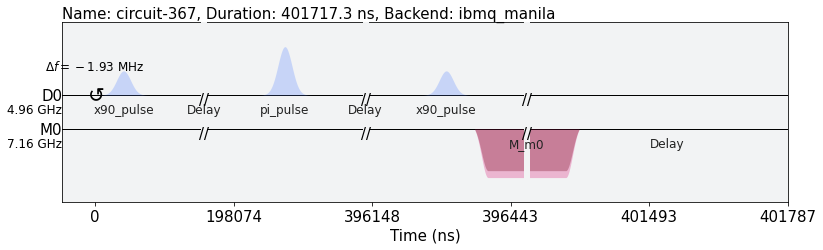

In [74]:
t2_schedule = schedule(exp_t2_circs[-1], backend)
t2_schedule.draw(backend=backend)

In [75]:
# Execution settings
num_shots_per_point = 512

job = backend.run(exp_t2_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [76]:
t2_results = job.result(timeout=120)

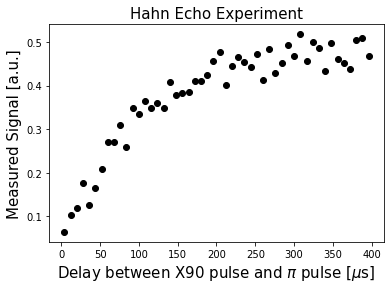

In [77]:
t2_values = []

for i in range(len(delay_times_sec)):
    iq_data = t2_results.get_memory(i)[:,qubit] * scale_factor
    t2_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.show()

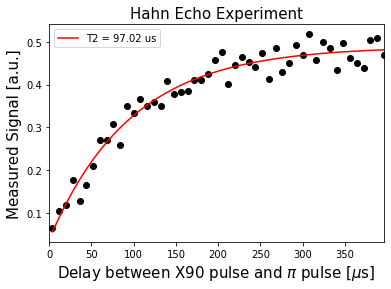

In [78]:
fit_params, y_fit = fit_function(2*delay_times_sec/us, t2_values,
             lambda x, A, B, T2: (A * np.exp(-x / T2) + B),
             [-3, 0, 100])

_, _, T2 = fit_params
print()

plt.scatter(2*delay_times_sec/us, t2_values, color='black')
plt.plot(2*delay_times_sec/us, y_fit, color='red', label=f"T2 = {T2:.2f} us")
plt.xlim(0, np.max(2*delay_times_sec/us))
plt.xlabel('Delay between X90 pulse and $\pi$ pulse [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Hahn Echo Experiment', fontsize=15)
plt.legend()
plt.show()

In [79]:
# DD experiment parameters
tau_sec_min = 1 * us
tau_sec_max = 180 * us
tau_step_sec = 4 * us
taus_sec = np.arange(tau_sec_min, tau_sec_max, tau_step_sec)

num_sequence = 1 # apply 1 sequence
print(f"Total time ranges from {2.*num_sequence*taus_sec[0] / us} to {2.*num_sequence*taus_sec[-1] / us} us")

Total time ranges from 2.0 to 354.0 us


In [80]:
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="T2DD delay Experiment") as T2DD_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(precise_qubit_freq, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay/2, drive_chan)
    for loop_counts in range(num_sequence):
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        pulse.call(pi_pulse)
        pulse.delay(delay, drive_chan)
        with pulse.phase_offset(np.pi/2, pulse.drive_channel(qubit)):
            pulse.call(pi_pulse)
        if loop_counts != num_sequence-1:
            pulse.delay(delay, drive_chan)
    pulse.delay(delay/2, drive_chan)
    pulse.call(x90_pulse)

In [81]:
T2DD_gate = Gate("T2DD", 1, [delay])

qc_T2DD = QuantumCircuit(1, 1)

qc_T2DD.append(T2DD_gate, [0])
qc_T2DD.measure(0, 0)
qc_T2DD.add_calibration(T2DD_gate, (0,), T2DD_schedule, [delay])

exp_T2DD_circs = [qc_T2DD.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in taus_sec]

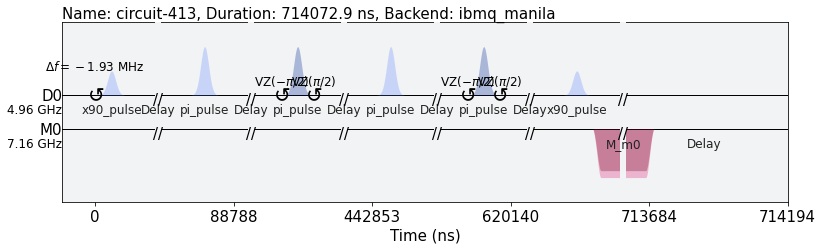

In [82]:
T2DD_schedule = schedule(exp_T2DD_circs[-1], backend)
T2DD_schedule.draw(backend=backend)

In [83]:
num_shots_per_point = 1024

job = backend.run(exp_T2DD_circs,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots_per_point)


job_monitor(job)

Job Status: job has successfully run


In [84]:
T2DD_results = job.result(timeout=120)

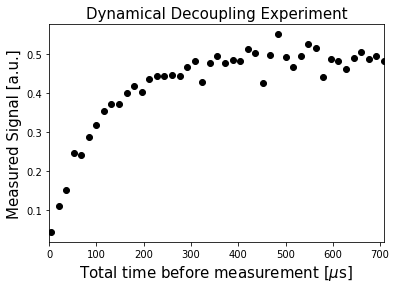

In [85]:
times_sec = 4*num_sequence*taus_sec
DD_values = []

for i in range(len(times_sec)):
    iq_data = T2DD_results.get_memory(i)[:,qubit] * scale_factor
    DD_values.append(sum(map(classify, iq_data)) / num_shots_per_point)

plt.scatter(times_sec/us, DD_values, color='black')
plt.xlim(0, np.max(times_sec/us))
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.show()

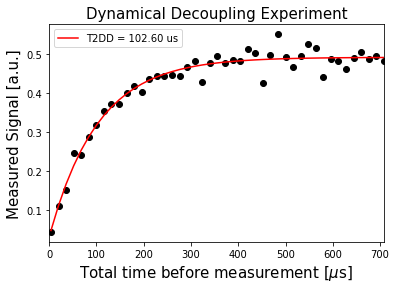

In [86]:
# Fit the data
fit_func = lambda x, A, B, T2DD: (A * np.exp(-x / T2DD) + B)
fitparams, conv = curve_fit(fit_func, times_sec/us, DD_values, [3.5, 0.8, 150])

_, _, T2DD = fitparams
plt.scatter(times_sec/us, DD_values, color='black')
plt.plot(times_sec/us, fit_func(times_sec/us, *fitparams), color='red', label=f"T2DD = {T2DD:.2f} us")
plt.xlim([0, np.max(times_sec/us)])
plt.xlabel('Total time before measurement [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.title('Dynamical Decoupling Experiment', fontsize=15)
plt.legend()
plt.show()

In [89]:
### Prueba 

In [90]:
# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [96]:
detuning_MHz = 2 
ramsey_frequency = round(precise_qubit_freq + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [97]:
# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [98]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

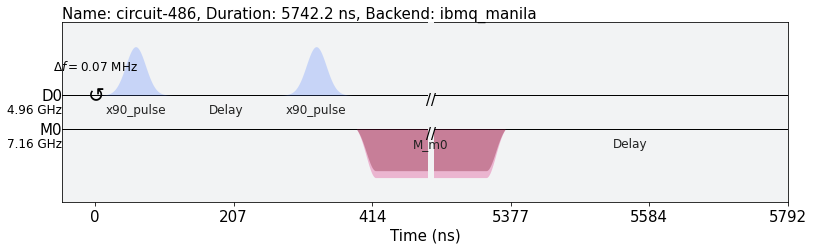

In [99]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [100]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [101]:
ramsey_results = job.result(timeout=120)

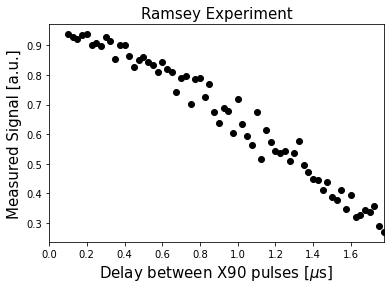

In [102]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()

In [103]:
qubit2=1

In [104]:
# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0.1 * us, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)
    
with pulse.build(backend) as x90_pulse_2:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit2)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='x90_pulse'), drive_chan)

In [108]:
detuning_MHz = 2 
ramsey_frequency = round(precise_qubit_freq + detuning_MHz * MHz, 6) # need ramsey freq in Hz

In [109]:
# create schedules for Ramsey experiment 

delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    with pulse.align_left():
        pulse.call(x90_pulse)
        pulse.call(x90_pulse_2)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)

In [110]:
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(2, 2)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0,0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]

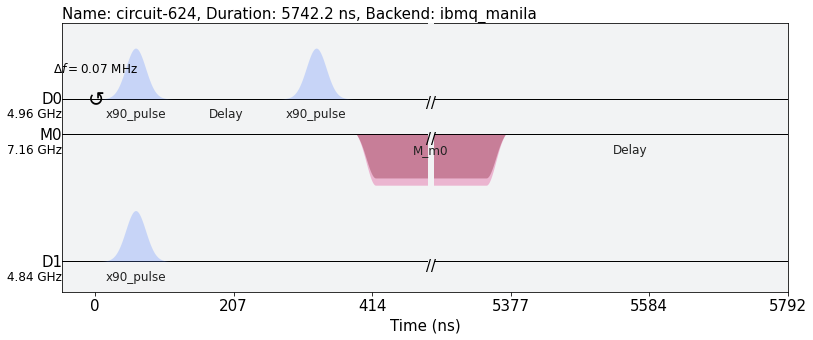

In [111]:
ramsey_schedule = schedule(exp_ramsey_circs[2], backend)
ramsey_schedule.draw(backend=backend)

In [112]:
# Execution settings
num_shots = 256

job = backend.run(exp_ramsey_circs, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [113]:
ramsey_results = job.result(timeout=120)

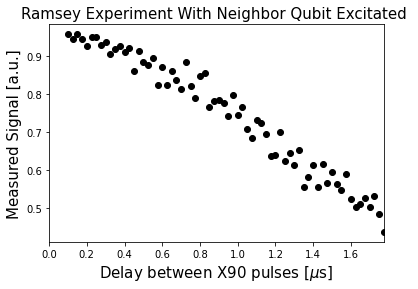

In [114]:
ramsey_values = []

for i in range(len(delay_times_sec)):
    iq_data = ramsey_results.get_memory(i)[:,qubit] * scale_factor
    ramsey_values.append(sum(map(classify, iq_data)) / num_shots)
    
plt.scatter(delay_times_sec/us, np.real(ramsey_values), color='black')
plt.xlim(0, np.max(delay_times_sec/us))
plt.title("Ramsey Experiment With Neighbor Qubit Excitated ", fontsize=15)
plt.xlabel('Delay between X90 pulses [$\mu$s]', fontsize=15)
plt.ylabel('Measured Signal [a.u.]', fontsize=15)
plt.show()